# ELG7186 - Fall 2022 - Assignment 3
## Due: <strong>Wednesday Nov. 23<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li> 
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


In [122]:
# Prepare your dataset here

## Import libraries

In [2]:
import os

import pandas as pd
import numpy as np
import cv2
#Connect drive to colab
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Conv2D,Dropout, MaxPooling2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
from tensorflow.keras import Model, losses, models, layers
from tensorflow.keras.losses import MeanSquaredLogarithmicError

from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

from keras.callbacks import ReduceLROnPlateau

from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from skimage import io

from sklearn.metrics import confusion_matrix


In [3]:
#Connect drive with colab
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Load images function to to read the images in a dataframe
def load_images_from_folder(folderBig):
    i = 0
    index = 0
    df = pd.DataFrame(columns=['imgs', 'labels'])
    for folder in os.listdir(folderBig):
      for filename in os.listdir(folderBig + '/' +folder):
        img = cv2.imread(folderBig+ '/' +folder+ '/' +filename)
          
        if img is not None:
            # df['imgs'].append(img)
            # df['labels'].append(i)
            df.at[index, 'imgs'] = img
            df.at[index, 'labels'] = i
            index +=1
      i = i+1
    return df

Classes will be [0,1,2,3,4]

In [5]:
##Read the test and train dataset
train =  load_images_from_folder('/content/drive/MyDrive/CV/Assg3/training')
test =  load_images_from_folder('/content/drive/MyDrive/CV/Assg3/testing')

In [127]:
#First five row of train dataset
train.head()

,imgs,labels
0,"[[[80, 95, 121], [77, 93, 116], [85, 101, 124]...",0
1,"[[[86, 86, 98], [87, 87, 99], [88, 88, 100], [...",0
2,"[[[61, 63, 74], [57, 59, 70], [62, 64, 75], [5...",0
3,"[[[74, 73, 82], [80, 82, 90], [81, 83, 91], [8...",0
4,"[[[110, 112, 122], [105, 107, 117], [104, 106,...",0


In [128]:
#Number of values in each class in train dataset
train.labels.value_counts()

0    180
1    180
2    180
3    180
4    180
Name: labels, dtype: int64

In [121]:
#First five row of test dataset
test.head()

,imgs,labels
0,"[[[16, 15, 19], [13, 9, 14], [12, 8, 13], [13,...",0
1,"[[[78, 78, 84], [74, 74, 80], [69, 72, 77], [6...",0
2,"[[[91, 91, 97], [92, 92, 98], [89, 89, 95], [8...",0
3,"[[[47, 50, 65], [44, 49, 64], [73, 78, 93], [8...",0
4,"[[[91, 93, 103], [87, 89, 99], [82, 84, 94], [...",0


In [130]:
#Number of values in each class in test dataset
test.labels.value_counts()

0    20
1    20
2    20
3    20
4    20
Name: labels, dtype: int64

In [131]:
# Shapes of train and test dataset
train.shape, test.shape

((900, 2), (100, 2))

### Visualize five images from the dataset.

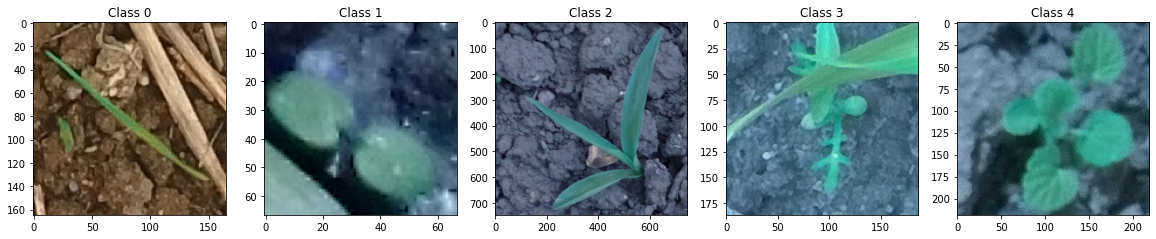

In [ ]:
fig = plt.figure(figsize=(20,200)) # specifying the overall grid size
row = 5
col = 5
k = -1
idx = 1

for i in range(0,5):
    k += 1
    img = train[train['labels']==k].sample(n=1, random_state=1)['imgs']
    for j in img:
       fig.add_subplot(row, col, idx)
       Class =  'Class '+ str(k)
       plt.title(Class)
       plt.imshow(j)
       idx += 1

Confuion Matrix Function

In [6]:
#
# Print the confusion matrix using Matplotlib
#
def conf(conf_mat):
  fig, ax = plt.subplots(figsize=(7, 8))
  ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)

  for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
      ax.text(x=j, y=i,s=conf_mat[i, j], va='center', ha='center', size='xx-large')

  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

### Split the training data to train and validation dataset

In [7]:
# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(train['imgs'], train['labels'], 
    stratify= train['labels'], test_size=100, random_state= 8) # 0.25 x 0.8 = 0.2

In [8]:
X_test = test['imgs']
y_test = test['labels']

In [9]:
X_train.shape, X_val.shape, X_test.shape

((800,), (100,), (100,))

In [10]:
y_train.shape, y_val.shape, y_test.shape

((800,), (100,), (100,))

### Resize images

In [11]:
def resize_data(data):  
    data_upscaled = np.zeros((data.shape[0], 64, 64, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

x_train_resized = resize_data(X_train) 
x_val_resized = resize_data(X_val)  
x_test_resized = resize_data(X_test)  

x_train_resized = x_train_resized / 255  
x_test_resized = x_test_resized / 255  
x_val_resized = x_val_resized / 255  

In [12]:
x_train_resized =np.asarray(x_train_resized).astype(np.float32) 
x_test_resized =np.asarray(x_test_resized).astype(np.float32) 
x_val_resized =np.asarray(x_val_resized).astype(np.float32) 

y_train =np.asarray(y_train).astype(np.float32)
y_test =np.asarray(y_test).astype(np.float32)
y_val =np.asarray(y_val).astype(np.float32)

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [12]:
# Write your code here

### VGG-16 Classification

In [13]:
# input  
input = Input(shape =(64,64,3))

In [14]:
input

<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'input_1')>

In [15]:
# Block 1 and 2 from VGG-16

def VGG(input):
    ## 1st Conv Block
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu', name='block1_conv1')(input)
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu',name='block1_conv2')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same', name='block1_pool')(x)

    ## 2nd Conv Block
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu',name='block2_conv1')(x)
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu', name='block2_conv2')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same', name='block2_pool')(x)
    return x

In [140]:
# Extra Keras Layers (no more than five fully connected or convolutional layers including the final output layer. ) 
x = VGG(input)

x = Conv2D (filters =70, kernel_size =2, activation='relu')(x)
x = Flatten()(x) 
x = Dense(units = 4096, activation ='relu')(x) 
x = Dense(units = 4096, activation ='relu')(x) 
output = Dense(units = 5, activation ='softmax')(x)


In [141]:
# creating the model
model = Model (inputs=input, outputs =output)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

In [69]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.fit(x_train_resized, y_train, batch_size=84, epochs=30, validation_data=(x_val_resized, y_val))

Epoch 1/30
10/10 [==============================] - 42s 4s/step - loss: 1.8308 - accuracy: 0.1950 - val_loss: 1.6099 - val_accuracy: 0.2000
Epoch 2/30
10/10 [==============================] - 39s 4s/step - loss: 1.6109 - accuracy: 0.2138 - val_loss: 1.6103 - val_accuracy: 0.2000
Epoch 3/30
10/10 [==============================] - 37s 4s/step - loss: 1.6087 - accuracy: 0.2237 - val_loss: 1.5978 - val_accuracy: 0.2600
Epoch 4/30
10/10 [==============================] - 39s 4s/step - loss: 1.6063 - accuracy: 0.1988 - val_loss: 1.5941 - val_accuracy: 0.2200
Epoch 5/30
10/10 [==============================] - 38s 4s/step - loss: 1.5590 - accuracy: 0.2650 - val_loss: 1.5427 - val_accuracy: 0.3300
Epoch 6/30
10/10 [==============================] - 37s 4s/step - loss: 1.5329 - accuracy: 0.2912 - val_loss: 1.5443 - val_accuracy: 0.3800
Epoch 7/30
10/10 [==============================] - 38s 4s/step - loss: 1.4730 - accuracy: 0.3600 - val_loss: 1.4694 - val_accuracy: 0.4000
Epoch 8/30
10/10 [==

In [70]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Plot a loss curve for training and validation data


In [76]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']


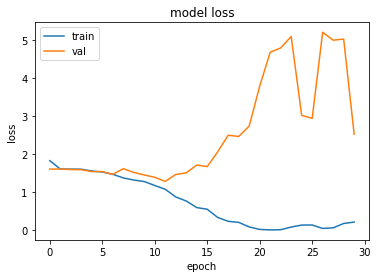

In [77]:
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Plot an accuracy curve for training and validation data


In [78]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

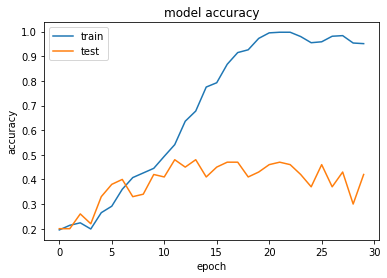

In [79]:
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Provide confusion matrix of your network on the training including validation and testing data sets


##### Trainig Confuison Matrix

In [80]:
yhat_train_m1 = model.predict(x_train_resized)

25/25 [==============================] - 11s 432ms/step


In [93]:
y_pred = yhat_train_m1.argmax(axis=1)
y_pred

array([2, 3, 3, 4, 2, 1, 2, 0, 0, 2, 3, 2, 2, 3, 4, 3, 2, 1, 1, 0, 3, 0,
       4, 4, 1, 4, 2, 2, 4, 2, 3, 2, 2, 1, 4, 2, 4, 0, 2, 2, 3, 0, 0, 2,
       2, 2, 3, 3, 1, 2, 1, 0, 1, 4, 3, 3, 2, 0, 2, 0, 4, 1, 1, 1, 1, 2,
       1, 4, 1, 2, 3, 2, 3, 3, 4, 1, 0, 0, 1, 2, 4, 1, 0, 3, 1, 4, 0, 4,
       4, 1, 1, 2, 4, 3, 1, 2, 1, 1, 1, 2, 3, 1, 2, 4, 2, 3, 2, 3, 1, 1,
       4, 0, 1, 4, 4, 0, 3, 3, 4, 1, 4, 1, 1, 1, 0, 4, 2, 4, 1, 1, 3, 4,
       3, 3, 0, 4, 2, 4, 3, 4, 0, 3, 2, 2, 0, 4, 4, 4, 2, 1, 1, 4, 4, 1,
       2, 3, 1, 3, 0, 4, 4, 3, 1, 0, 4, 0, 1, 4, 0, 4, 1, 3, 0, 4, 4, 1,
       3, 3, 4, 1, 0, 1, 3, 1, 2, 3, 4, 0, 0, 0, 1, 2, 1, 4, 0, 3, 4, 2,
       4, 4, 1, 0, 2, 1, 3, 0, 0, 3, 1, 1, 0, 1, 3, 1, 0, 2, 2, 0, 0, 4,
       0, 4, 3, 4, 0, 1, 0, 3, 2, 1, 2, 4, 4, 3, 4, 3, 3, 1, 2, 3, 1, 1,
       0, 3, 0, 4, 0, 3, 4, 0, 2, 0, 2, 1, 4, 2, 2, 4, 3, 2, 0, 3, 3, 2,
       3, 4, 4, 0, 4, 4, 2, 4, 1, 0, 4, 4, 2, 4, 2, 0, 3, 4, 2, 4, 1, 0,
       2, 1, 4, 0, 0, 4, 4, 3, 4, 1, 4, 0, 4, 1, 0,

In [95]:
conf_matrix = confusion_matrix(y_true=y_train, y_pred=y_pred)
conf_matrix

array([[160,   0,   0,   0,   0],
       [  1, 158,   0,   0,   1],
       [  0,   0, 160,   0,   0],
       [  1,   0,   0, 153,   6],
       [  0,   0,   0,   0, 160]])

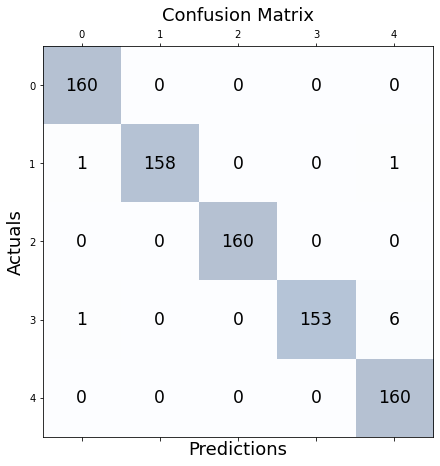

In [96]:
conf(conf_matrix)

##### Val Confuison Matrix

In [97]:
yhat_val_m1 = model.predict(x_val_resized)

4/4 [==============================] - 1s 286ms/step


In [98]:
yhat_val_m1 

array([[4.44853127e-01, 4.73292544e-04, 3.10246064e-03, 4.82188076e-01,
        6.93830550e-02],
       [1.14070821e-13, 3.71335176e-07, 9.99968708e-01, 1.54650497e-05,
        1.53666679e-05],
       [1.47954910e-04, 5.50825644e-05, 1.59081756e-04, 2.93714166e-01,
        7.05923796e-01],
       [1.67236233e-03, 5.50891215e-04, 1.41269550e-01, 8.49652946e-01,
        6.85411226e-03],
       [1.72730982e-02, 3.17101717e-01, 9.71322320e-03, 6.55068219e-01,
        8.43832211e-04],
       [9.99999940e-01, 1.72630075e-14, 3.12677943e-14, 7.30316466e-15,
        5.76125722e-15],
       [6.34088833e-03, 3.72359246e-01, 5.44052720e-01, 4.02866909e-03,
        7.32184127e-02],
       [9.99999821e-01, 1.39453629e-10, 9.59520352e-10, 3.58963459e-09,
        1.10087740e-07],
       [9.97495949e-01, 2.07414571e-03, 2.55720573e-04, 1.71205422e-04,
        2.90020398e-06],
       [2.47260650e-05, 4.65602752e-05, 1.45287463e-03, 8.07972066e-03,
        9.90396202e-01],
       [1.10676579e-01, 8.0629

In [99]:
y_pred2 = yhat_val_m1.argmax(axis=1)
y_pred2

array([3, 2, 4, 3, 3, 0, 2, 0, 0, 4, 1, 4, 3, 1, 0, 0, 0, 1, 2, 0, 4, 1,
       0, 3, 4, 2, 3, 4, 2, 0, 4, 0, 4, 0, 4, 0, 4, 2, 4, 1, 4, 3, 0, 1,
       2, 1, 0, 0, 1, 4, 2, 1, 4, 1, 4, 2, 1, 0, 0, 2, 1, 2, 2, 2, 0, 4,
       4, 3, 1, 2, 2, 1, 0, 2, 1, 0, 4, 0, 1, 4, 1, 1, 4, 1, 4, 2, 3, 0,
       0, 2, 0, 0, 0, 4, 3, 4, 4, 0, 2, 1])

In [100]:
conf_matrix2 = confusion_matrix(y_true=y_val, y_pred=y_pred2)
conf_matrix2

array([[16,  2,  2,  0,  0],
       [ 3,  8,  5,  2,  2],
       [ 4,  3,  5,  4,  4],
       [ 3,  4,  2,  3,  8],
       [ 1,  3,  5,  1, 10]])

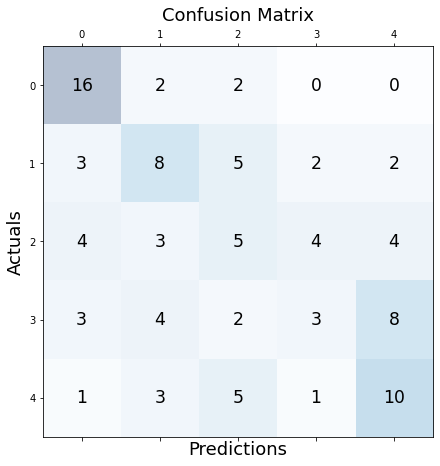

In [101]:
conf(conf_matrix2)

##### Testing Confuison Matrix

In [102]:
yhat_test_m1 = model.predict(x_test_resized)

4/4 [==============================] - 1s 355ms/step


In [104]:
y_pred3 = yhat_test_m1.argmax(axis=1)
y_pred3

array([0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 1, 4, 0, 2, 2, 0, 4, 1, 4, 0, 0, 1, 2, 2, 3, 4, 4, 4, 2, 4, 0,
       0, 4, 4, 4, 4, 2, 1, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 3, 2, 1, 0, 0, 1, 0, 2, 2, 1, 3, 2, 2, 1, 1,
       2, 4, 2, 0, 2, 0, 2, 4, 2, 1, 4, 4])

In [105]:
conf_matrix3 = confusion_matrix(y_true=y_test, y_pred=y_pred3)
conf_matrix3

array([[17,  1,  1,  0,  1],
       [ 4,  3,  4,  1,  8],
       [ 2,  1,  3,  0, 14],
       [ 7, 10,  1,  2,  0],
       [ 2,  4,  9,  1,  4]])

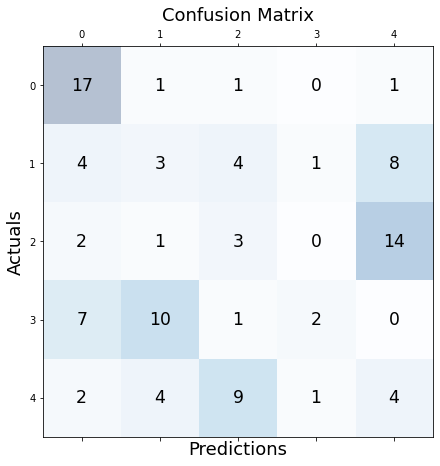

In [106]:
conf(conf_matrix3)

## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)




In [ ]:
#Write your code here

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

### Regressor model

In [25]:
# Extra Keras Layers (no more than five fully connected or convolutional layers including the final output layer. ) 
x = VGG(input)
x = Conv2D (filters =70, kernel_size =2, activation='relu')(x)
x = Flatten()(x) 
x = Dense(units = 4096, activation ='relu')(x) 
x = Dense(units = 4096, activation ='relu')(x) 
output = Dense(units = 1, activation ='linear')(x)


In [45]:
# creating the model
model_Reg = Model (inputs=input, outputs =output)
model_Reg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [51]:
model_Reg.compile(optimizer='adam', loss=losses.mse, metrics=['accuracy'])
model_Reg.fit(x_train_resized, y_train, batch_size=84, epochs=30, validation_data=(x_val_resized, y_val))

Epoch 1/30
10/10 [==============================] - 57s 6s/step - loss: 27.8459 - accuracy: 0.1937 - val_loss: 5.5664 - val_accuracy: 0.2000
Epoch 2/30
10/10 [==============================] - 54s 5s/step - loss: 3.4461 - accuracy: 0.1950 - val_loss: 2.4900 - val_accuracy: 0.2000
Epoch 3/30
10/10 [==============================] - 54s 5s/step - loss: 2.1216 - accuracy: 0.2000 - val_loss: 2.1454 - val_accuracy: 0.2000
Epoch 4/30
10/10 [==============================] - 56s 5s/step - loss: 2.0582 - accuracy: 0.2000 - val_loss: 1.9098 - val_accuracy: 0.2000
Epoch 5/30
10/10 [==============================] - 57s 6s/step - loss: 1.9122 - accuracy: 0.2000 - val_loss: 1.6255 - val_accuracy: 0.2000
Epoch 6/30
10/10 [==============================] - 56s 6s/step - loss: 1.7607 - accuracy: 0.2000 - val_loss: 1.6679 - val_accuracy: 0.2000
Epoch 7/30
10/10 [==============================] - 55s 6s/step - loss: 1.7836 - accuracy: 0.2000 - val_loss: 1.5327 - val_accuracy: 0.2000
Epoch 8/30
10/10 [=

#### Plot a loss curve for training and validation data


In [52]:
loss = model_Reg.history.history['loss']
val_loss = model_Reg.history.history['val_loss']

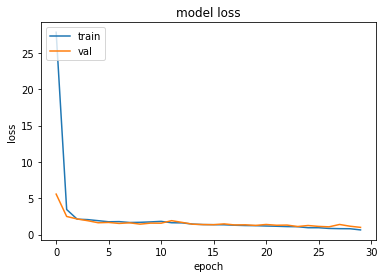

In [53]:
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Plot an accuracy curve for training and validation data


In [54]:
accuracy = model_Reg.history.history['accuracy']
val_accuracy = model_Reg.history.history['val_accuracy']

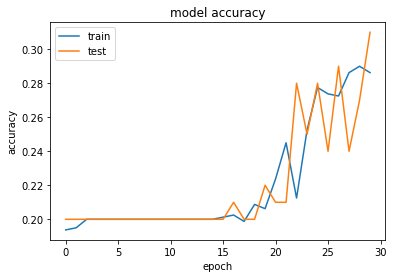

In [55]:
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Provide confusion matrix of your network on the training including validation and testing data sets


##### Trainig Confuison Matrix

In [56]:
yhat_train_m2 = model_Reg.predict(x_train_resized)

25/25 [==============================] - 14s 566ms/step


In [57]:
yhat_train_m2

array([[ 3.44279385e+00],
       [ 2.87771130e+00],
       [ 2.95929384e+00],
       [ 4.51924944e+00],
       [ 2.31990623e+00],
       [ 1.33007884e+00],
       [ 2.54346561e+00],
       [ 9.25929844e-02],
       [ 3.23808849e-01],
       [ 1.45822501e+00],
       [ 2.84788561e+00],
       [ 1.46776283e+00],
       [ 2.07090545e+00],
       [ 2.12044334e+00],
       [ 3.10641956e+00],
       [ 2.41472363e+00],
       [ 1.58086598e+00],
       [ 1.44497120e+00],
       [ 1.13921118e+00],
       [ 4.60630991e-02],
       [ 3.60109377e+00],
       [-2.38815099e-02],
       [ 3.96332908e+00],
       [ 4.46232271e+00],
       [ 2.56286812e+00],
       [ 4.09126139e+00],
       [ 2.69508719e+00],
       [ 3.04802442e+00],
       [ 4.47503328e+00],
       [ 3.33440113e+00],
       [ 3.26823664e+00],
       [ 1.58315384e+00],
       [ 1.99421310e+00],
       [ 4.17173952e-01],
       [ 4.03215504e+00],
       [ 3.60270119e+00],
       [ 4.95659065e+00],
       [ 2.40709186e-01],
       [ 2.2

In [75]:
y_pred21=np.rint(yhat_train_m2).astype(int)
y_pred21

array([[3],
       [3],
       [3],
       [5],
       [2],
       [1],
       [3],
       [0],
       [0],
       [1],
       [3],
       [1],
       [2],
       [2],
       [3],
       [2],
       [2],
       [1],
       [1],
       [0],
       [4],
       [0],
       [4],
       [4],
       [3],
       [4],
       [3],
       [3],
       [4],
       [3],
       [3],
       [2],
       [2],
       [0],
       [4],
       [4],
       [5],
       [0],
       [2],
       [2],
       [3],
       [0],
       [2],
       [2],
       [2],
       [2],
       [3],
       [2],
       [1],
       [1],
       [2],
       [0],
       [2],
       [3],
       [2],
       [3],
       [1],
       [0],
       [1],
       [1],
       [4],
       [2],
       [0],
       [2],
       [2],
       [1],
       [1],
       [4],
       [1],
       [2],
       [4],
       [2],
       [3],
       [3],
       [4],
       [1],
       [2],
       [0],
       [1],
       [1],
       [3],
       [2],
       [0],
    

In [76]:
conf_matrix21 = confusion_matrix(y_true=y_train, y_pred=y_pred21)
conf_matrix21

array([[105,  41,  13,   1,   0,   0],
       [ 13,  68,  69,  10,   0,   0],
       [  0,  36,  66,  55,   3,   0],
       [  0,   4,  42,  88,  26,   0],
       [  0,   0,   9,  68,  74,   9],
       [  0,   0,   0,   0,   0,   0]])

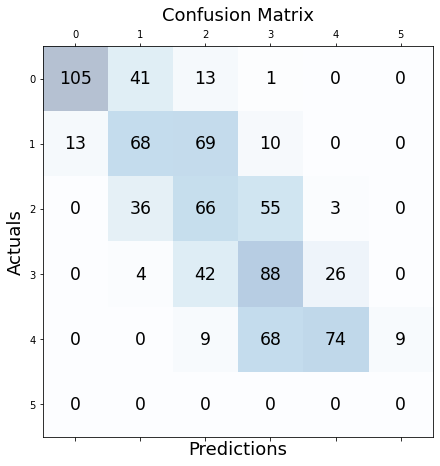

In [77]:
conf(conf_matrix21)

##### Val Confuison Matrix

In [78]:
yhat_val_m2 = model_Reg.predict(x_val_resized)

4/4 [==============================] - 2s 416ms/step


In [79]:
yhat_val_m2

array([[ 1.9401857e+00],
       [ 2.9443212e+00],
       [ 3.8924971e+00],
       [ 2.8534081e+00],
       [ 2.1734123e+00],
       [ 2.7693223e-02],
       [ 1.9851394e+00],
       [-2.2501588e-02],
       [ 1.0712920e+00],
       [ 5.1025114e+00],
       [ 1.3070604e+00],
       [ 4.4510112e+00],
       [ 3.3312941e+00],
       [ 3.4386139e+00],
       [ 1.9351407e+00],
       [ 4.5564163e-01],
       [ 3.5103993e+00],
       [ 2.8887439e+00],
       [ 1.2905314e+00],
       [ 2.5039423e-01],
       [ 2.4320223e+00],
       [ 1.7742630e+00],
       [ 4.8288298e-01],
       [ 1.9425091e+00],
       [ 2.2172713e+00],
       [ 2.8913190e+00],
       [ 1.7442999e+00],
       [ 2.7054670e+00],
       [ 2.4376023e+00],
       [ 2.2058663e+00],
       [ 2.0709143e+00],
       [ 5.8863109e-01],
       [ 4.1111798e+00],
       [ 2.3200583e+00],
       [ 3.9473343e+00],
       [ 1.2026689e+00],
       [ 1.6601232e+00],
       [ 2.4998331e+00],
       [ 3.3322952e+00],
       [ 1.9440542e+00],


In [80]:
y_pred22 = np.rint(yhat_val_m2).astype(int)
y_pred22

array([[2],
       [3],
       [4],
       [3],
       [2],
       [0],
       [2],
       [0],
       [1],
       [5],
       [1],
       [4],
       [3],
       [3],
       [2],
       [0],
       [4],
       [3],
       [1],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [3],
       [2],
       [3],
       [2],
       [2],
       [2],
       [1],
       [4],
       [2],
       [4],
       [1],
       [2],
       [2],
       [3],
       [2],
       [2],
       [1],
       [0],
       [1],
       [1],
       [3],
       [1],
       [1],
       [2],
       [3],
       [3],
       [3],
       [4],
       [2],
       [3],
       [4],
       [2],
       [2],
       [0],
       [3],
       [3],
       [2],
       [1],
       [3],
       [0],
       [4],
       [3],
       [3],
       [2],
       [2],
       [2],
       [3],
       [0],
       [2],
       [2],
       [1],
       [1],
       [0],
       [2],
       [3],
       [2],
       [1],
       [4],
    

In [81]:
conf_matrix22 = confusion_matrix(y_true=y_val, y_pred=y_pred22)
conf_matrix22

array([[12,  6,  2,  0,  0,  0],
       [ 1,  6, 12,  1,  0,  0],
       [ 0,  2,  8,  9,  1,  0],
       [ 1,  0,  7, 10,  2,  0],
       [ 0,  1,  4,  7,  7,  1],
       [ 0,  0,  0,  0,  0,  0]])

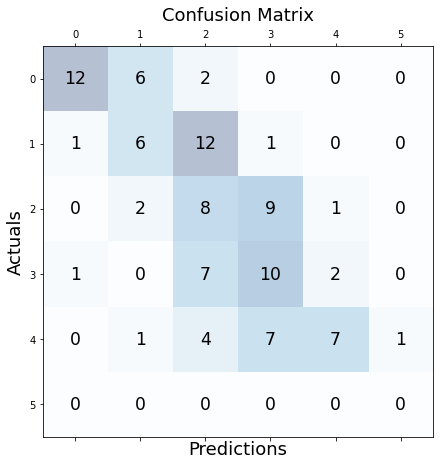

In [82]:
conf(conf_matrix22)

##### Testing Confuison Matrix

In [83]:
yhat_test_m2 = model_Reg.predict(x_test_resized)

4/4 [==============================] - 2s 416ms/step


In [84]:
y_pred23 = np.rint(yhat_val_m2).astype(int)
y_pred23

array([[2],
       [3],
       [4],
       [3],
       [2],
       [0],
       [2],
       [0],
       [1],
       [5],
       [1],
       [4],
       [3],
       [3],
       [2],
       [0],
       [4],
       [3],
       [1],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [3],
       [2],
       [3],
       [2],
       [2],
       [2],
       [1],
       [4],
       [2],
       [4],
       [1],
       [2],
       [2],
       [3],
       [2],
       [2],
       [1],
       [0],
       [1],
       [1],
       [3],
       [1],
       [1],
       [2],
       [3],
       [3],
       [3],
       [4],
       [2],
       [3],
       [4],
       [2],
       [2],
       [0],
       [3],
       [3],
       [2],
       [1],
       [3],
       [0],
       [4],
       [3],
       [3],
       [2],
       [2],
       [2],
       [3],
       [0],
       [2],
       [2],
       [1],
       [1],
       [0],
       [2],
       [3],
       [2],
       [1],
       [4],
    

In [85]:
conf_matrix23 = confusion_matrix(y_true=y_test, y_pred=y_pred23)
conf_matrix23

array([[ 4,  3,  4,  5,  3,  1],
       [ 1,  2, 12,  3,  2,  0],
       [ 2,  5,  5,  6,  2,  0],
       [ 3,  3,  7,  6,  1,  0],
       [ 4,  2,  5,  7,  2,  0],
       [ 0,  0,  0,  0,  0,  0]])

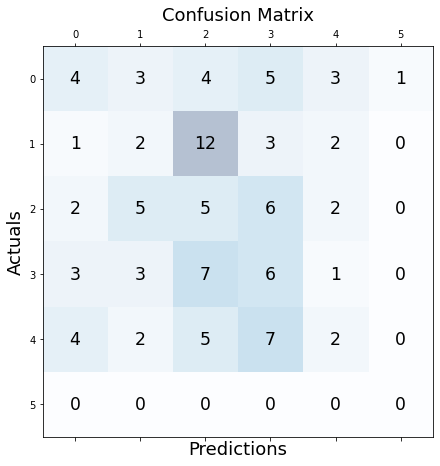

In [86]:
conf(conf_matrix23)

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

<b>Classification part:</b> 
* loss: 0.2151 -
* accuracy: 0.9513 - 
* val_loss: 2.5282 - 
* val_accuracy: 0.4200 <br>

which means that the data saffer from over fitting as the model captures the pattern of the training dataset and starts caching noise and inaccurate values present in the dataset and couldn't represent all possible data, so it failed in generalize unseen dataset(testing data)

Regression part: 
* loss: 0.6396 - 
* accuracy: 0.2862 - 
* val_loss: 0.9892 - 
* val_accuracy: 0.3100

the model has a bad performance in training and testing dataset.

## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.


 

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.

In [ ]:
# Write your code here

In [19]:
# The VGG Blocks
# x = Conv2D (filters =70, kernel_size =3, activation='relu')(x)
# x = Dropout(0.5)(x) 
# x = BatchNormalization()(x)
# x = Dense(units = 1028, activation ='relu')(x) 
# x = Dense(1028, activation='sigmoid')(x)
# x = Flatten()(x) 
# x = Dropout(0.5)(x) 
# output = Dense(units = 5, activation ='softmax')(x)

x3 = VGG(input)
x3 = Conv2D (filters =70, kernel_size =2, activation='relu')(x3)
x3 = Flatten()(x3) 
x3 = Dense(units = 4096, activation ='relu')(x3) 
x3 = Dense(units = 4096, activation ='sigmoid')(x3) 
x3 = Dropout(0.33)(x3) 
x3 = Dense(units = 4096, activation ='relu')(x3) 
output = Dense(units = 5, activation ='softmax')(x3)



In [20]:
# creating the model
model3 = Model (inputs=input, outputs =output)
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [18]:
batch_size = 86
epochs=30 

In [20]:
optimizer = tf.keras.optimizers.Adam(0.00001)
model3.compile(optimizer=optimizer, loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

model3.fit(x_train_resized, y_train, batch_size=86, epochs=30, validation_data=(x_val_resized, y_val))

Epoch 1/30
10/10 [==============================] - 68s 6s/step - loss: 1.6881 - accuracy: 0.1875 - val_loss: 1.6647 - val_accuracy: 0.2100
Epoch 2/30
10/10 [==============================] - 63s 6s/step - loss: 1.6568 - accuracy: 0.2225 - val_loss: 1.6401 - val_accuracy: 0.2000
Epoch 3/30
10/10 [==============================] - 64s 6s/step - loss: 1.6792 - accuracy: 0.1725 - val_loss: 1.6100 - val_accuracy: 0.2000
Epoch 4/30
10/10 [==============================] - 65s 6s/step - loss: 1.6630 - accuracy: 0.1875 - val_loss: 1.6112 - val_accuracy: 0.2000
Epoch 5/30
10/10 [==============================] - 64s 6s/step - loss: 1.6418 - accuracy: 0.2175 - val_loss: 1.6049 - val_accuracy: 0.2000
Epoch 6/30
10/10 [==============================] - 64s 6s/step - loss: 1.6597 - accuracy: 0.1963 - val_loss: 1.6032 - val_accuracy: 0.2300
Epoch 7/30
10/10 [==============================] - 65s 6s/step - loss: 1.6293 - accuracy: 0.2300 - val_loss: 1.5997 - val_accuracy: 0.2200
Epoch 8/30
10/10 [==

#### Plot a loss curve for training and validation data


In [21]:
loss = model3.history.history['loss']
val_loss = model3.history.history['val_loss']

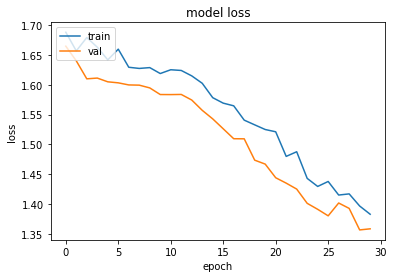

In [22]:
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Plot an accuracy curve for training and validation data


In [23]:
accuracy = model3.history.history['accuracy']
val_accuracy = model3.history.history['val_accuracy']

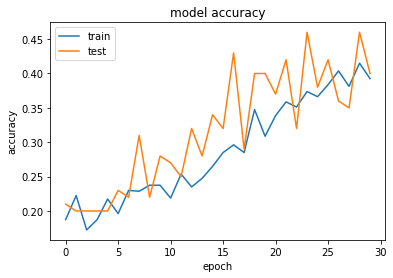

In [24]:
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Provide confusion matrix of your network on the training including validation and testing data sets


##### Trainig Confuison Matrix

In [25]:
yhat_train_m3 = model3.predict(x_train_resized)

25/25 [==============================] - 17s 671ms/step


In [26]:
yhat_train_m3

array([[0.00316369, 0.04412498, 0.18491344, 0.48648584, 0.28131208],
       [0.02152772, 0.23462753, 0.3036418 , 0.2985071 , 0.1416958 ],
       [0.0396614 , 0.22569102, 0.41723576, 0.21512015, 0.1022916 ],
       ...,
       [0.0211464 , 0.21272852, 0.32907864, 0.28532845, 0.15171805],
       [0.02186219, 0.40434745, 0.28662434, 0.20975551, 0.0774105 ],
       [0.26234055, 0.22246078, 0.20495726, 0.1403192 , 0.16992232]],
      dtype=float32)

In [27]:
y_pred31 = yhat_train_m3.argmax(axis=1)
y_pred31

array([3, 2, 2, 2, 2, 2, 2, 0, 1, 4, 4, 2, 3, 3, 3, 2, 2, 3, 1, 0, 3, 0,
       4, 4, 2, 3, 3, 3, 4, 2, 3, 2, 2, 4, 3, 3, 4, 0, 0, 2, 3, 0, 1, 3,
       3, 2, 3, 2, 0, 2, 1, 0, 2, 3, 4, 3, 0, 0, 4, 0, 3, 3, 0, 3, 2, 0,
       1, 4, 2, 2, 3, 2, 3, 2, 2, 2, 2, 0, 3, 2, 2, 2, 0, 0, 0, 2, 0, 3,
       4, 2, 2, 4, 2, 4, 2, 2, 2, 1, 3, 1, 3, 4, 4, 4, 2, 3, 2, 3, 2, 3,
       4, 0, 2, 2, 1, 0, 3, 2, 0, 1, 3, 1, 1, 2, 0, 2, 4, 2, 3, 3, 3, 3,
       2, 3, 4, 2, 2, 0, 4, 3, 0, 4, 3, 0, 0, 2, 3, 3, 3, 0, 2, 3, 3, 2,
       4, 3, 3, 3, 0, 3, 2, 3, 1, 2, 2, 0, 2, 3, 2, 3, 2, 2, 2, 2, 3, 4,
       2, 3, 4, 1, 0, 1, 0, 2, 3, 2, 4, 4, 4, 0, 1, 3, 0, 3, 3, 3, 3, 2,
       3, 3, 1, 4, 3, 3, 3, 1, 1, 3, 0, 0, 0, 1, 3, 1, 0, 2, 2, 2, 0, 3,
       1, 2, 3, 4, 0, 0, 0, 2, 3, 2, 3, 1, 2, 4, 2, 4, 4, 2, 3, 0, 2, 1,
       1, 4, 0, 3, 0, 3, 4, 0, 3, 2, 1, 3, 2, 2, 2, 1, 3, 3, 4, 3, 3, 2,
       3, 4, 4, 0, 4, 4, 4, 2, 1, 0, 2, 0, 3, 2, 2, 2, 4, 3, 2, 3, 0, 2,
       2, 3, 3, 1, 2, 0, 2, 4, 2, 1, 3, 2, 3, 1, 0,

In [28]:
conf_matrix31 = confusion_matrix(y_true=y_train, y_pred=y_pred31)
conf_matrix31

array([[103,  11,  28,   4,  14],
       [ 19,  49,  55,  27,  10],
       [ 15,  12,  84,  32,  17],
       [ 10,   3,  38,  83,  26],
       [  9,   6,  50,  49,  46]])

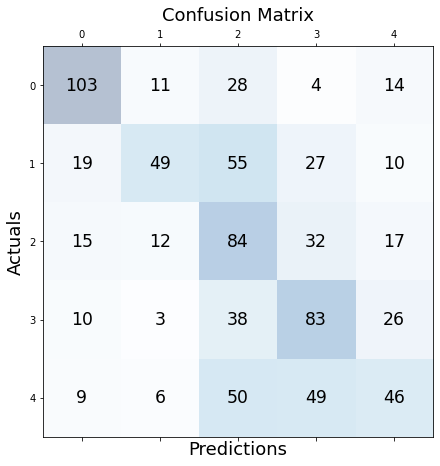

In [29]:
conf(conf_matrix31)

##### Val Confuison Matrix

In [30]:
yhat_val_m3 = model3.predict(x_val_resized)

4/4 [==============================] - 2s 518ms/step


In [31]:
yhat_val_m3

array([[6.95103332e-02, 8.93448368e-02, 2.75363207e-01, 2.93178082e-01,
        2.72603542e-01],
       [2.90268511e-02, 1.25366166e-01, 2.97363311e-01, 3.23242337e-01,
        2.25001395e-01],
       [2.31018960e-02, 5.07804453e-02, 1.59034938e-01, 3.38694125e-01,
        4.28388536e-01],
       [1.02599887e-02, 2.86481529e-01, 3.27049613e-01, 2.84687579e-01,
        9.15213078e-02],
       [7.21132979e-02, 2.43461102e-01, 2.72320867e-01, 2.36358285e-01,
        1.75746411e-01],
       [7.18082368e-01, 1.14240468e-01, 1.09936059e-01, 2.11010389e-02,
        3.66401449e-02],
       [8.59762207e-02, 2.42862135e-01, 3.50189090e-01, 1.77960292e-01,
        1.43012270e-01],
       [4.89405096e-01, 1.61429286e-01, 1.78380519e-01, 6.39086664e-02,
        1.06876336e-01],
       [1.63567007e-01, 1.63280681e-01, 2.47308582e-01, 1.82663873e-01,
        2.43179858e-01],
       [1.31258685e-02, 2.51310878e-02, 1.12382740e-01, 3.43706459e-01,
        5.05653799e-01],
       [1.24382578e-01, 1.5931

In [32]:
y_pred32 = yhat_val_m3.argmax(axis=1)
y_pred32

array([3, 3, 4, 2, 2, 0, 2, 0, 2, 4, 2, 2, 3, 2, 2, 0, 4, 3, 2, 0, 4, 3,
       0, 2, 2, 3, 3, 4, 3, 4, 3, 2, 3, 1, 4, 1, 2, 4, 3, 3, 2, 0, 0, 2,
       0, 2, 2, 4, 2, 3, 4, 3, 3, 2, 4, 2, 1, 2, 0, 3, 4, 2, 0, 4, 0, 4,
       0, 3, 1, 2, 2, 3, 0, 4, 2, 0, 1, 0, 1, 4, 3, 1, 3, 0, 2, 3, 3, 0,
       0, 3, 0, 0, 4, 3, 2, 4, 2, 0, 2, 3])

In [33]:
conf_matrix32 = confusion_matrix(y_true=y_val, y_pred=y_pred32)
conf_matrix32

array([[14,  0,  3,  1,  2],
       [ 2,  5,  8,  5,  0],
       [ 4,  2,  4,  4,  6],
       [ 1,  0,  8,  9,  2],
       [ 0,  0,  6,  6,  8]])

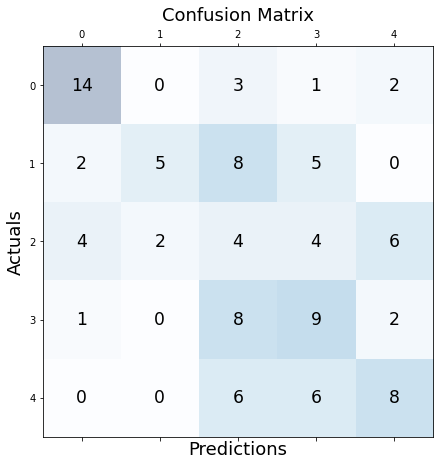

In [34]:
conf(conf_matrix32)

##### Testing Confuison Matrix

In [35]:
yhat_test_m3 = model3.predict(x_test_resized)

4/4 [==============================] - 2s 507ms/step


In [36]:
y_pred23 = yhat_test_m3.argmax(axis=1)
y_pred23

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 4, 0, 4, 2, 0, 2, 2, 1, 2, 4, 3, 3,
       3, 3, 4, 4, 3, 2, 0, 4, 3, 3, 1, 4, 3, 3, 3, 4, 4, 4, 3, 0, 3, 2,
       0, 3, 3, 4, 4, 2, 2, 3, 3, 2, 4, 3, 4, 4, 3, 3, 3, 1, 1, 2, 2, 1,
       2, 1, 2, 0, 2, 1, 1, 0, 2, 2, 4, 2, 4, 2, 3, 1, 1, 3, 2, 4, 3, 3,
       0, 3, 2, 0, 4, 2, 2, 3, 2, 2, 4, 3])

In [37]:
conf_matrix23 = confusion_matrix(y_true=y_test, y_pred=y_pred23)
conf_matrix23

array([[10,  3,  4,  0,  3],
       [ 1,  1,  1, 10,  7],
       [ 2,  0,  4,  9,  5],
       [ 2,  6,  9,  1,  2],
       [ 2,  2,  6,  7,  3]])

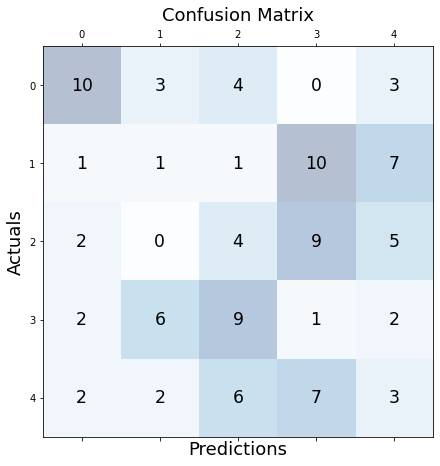

In [38]:
conf(conf_matrix23)

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.


In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_resized)

In [17]:
epochs = 30
batch_size = 86

In [21]:
# Fit the model
optimizer = tf.keras.optimizers.Adam(0.0001)

model3.compile(optimizer=optimizer, loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model3.fit_generator(datagen.flow(x_train_resized,y_train, batch_size=120),
                              epochs = epochs, validation_data = (x_val_resized,y_val))

Epoch 1/30
7/7 [==============================] - 45s 6s/step - loss: 2.6918 - accuracy: 0.1950 - val_loss: 2.1576 - val_accuracy: 0.2000
Epoch 2/30
7/7 [==============================] - 40s 6s/step - loss: 2.0809 - accuracy: 0.1863 - val_loss: 1.6792 - val_accuracy: 0.2000
Epoch 3/30
7/7 [==============================] - 39s 6s/step - loss: 1.8635 - accuracy: 0.2013 - val_loss: 1.7171 - val_accuracy: 0.2000
Epoch 4/30
7/7 [==============================] - 40s 6s/step - loss: 1.7197 - accuracy: 0.1975 - val_loss: 1.6129 - val_accuracy: 0.2000
Epoch 5/30
7/7 [==============================] - 40s 6s/step - loss: 1.6884 - accuracy: 0.1925 - val_loss: 1.6480 - val_accuracy: 0.2000
Epoch 6/30
7/7 [==============================] - 41s 6s/step - loss: 1.6507 - accuracy: 0.2138 - val_loss: 1.6045 - val_accuracy: 0.2500
Epoch 7/30
7/7 [==============================] - 41s 6s/step - loss: 1.6103 - accuracy: 0.2250 - val_loss: 1.5852 - val_accuracy: 0.2700
Epoch 8/30
7/7 [==================

#### Provide confusion matrix of your network on the training including validation and testing data sets


##### Trainig Confuison Matrix

In [22]:
yhat_train_m4 = model3.predict(x_train_resized)

25/25 [==============================] - 11s 422ms/step


In [23]:
y_pred41 = yhat_train_m4.argmax(axis=1)
y_pred41

array([3, 3, 3, 3, 2, 2, 2, 0, 0, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 0, 3, 0,
       4, 3, 1, 3, 3, 3, 4, 2, 3, 2, 2, 2, 4, 3, 4, 0, 4, 2, 3, 0, 2, 1,
       2, 2, 3, 3, 2, 2, 2, 0, 3, 3, 3, 3, 1, 0, 2, 0, 3, 3, 0, 2, 2, 2,
       2, 4, 2, 2, 3, 3, 3, 2, 4, 0, 2, 0, 1, 2, 2, 2, 0, 0, 0, 4, 0, 3,
       4, 2, 2, 3, 2, 3, 2, 3, 2, 1, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       3, 0, 2, 3, 2, 0, 3, 3, 3, 2, 3, 0, 1, 2, 0, 3, 3, 3, 2, 3, 3, 3,
       4, 2, 2, 2, 3, 3, 3, 3, 0, 3, 3, 3, 0, 4, 3, 3, 3, 0, 2, 3, 3, 2,
       3, 3, 3, 3, 0, 3, 2, 3, 1, 0, 4, 0, 2, 4, 0, 3, 2, 3, 0, 3, 3, 3,
       3, 3, 2, 1, 0, 2, 0, 2, 3, 3, 4, 3, 0, 0, 2, 3, 2, 3, 2, 3, 3, 2,
       4, 3, 2, 2, 3, 3, 3, 0, 1, 3, 0, 2, 0, 1, 3, 2, 0, 0, 2, 3, 0, 3,
       3, 4, 4, 3, 0, 2, 0, 3, 3, 2, 3, 3, 3, 4, 3, 2, 3, 2, 3, 0, 1, 2,
       1, 3, 0, 3, 0, 3, 4, 0, 3, 0, 3, 3, 3, 3, 2, 3, 3, 3, 0, 3, 2, 2,
       3, 3, 4, 0, 3, 3, 4, 3, 2, 0, 4, 3, 3, 3, 2, 0, 4, 3, 3, 3, 0, 2,
       2, 3, 3, 0, 2, 4, 2, 3, 3, 2, 3, 2, 3, 1, 0,

In [24]:
conf_matrix41 = confusion_matrix(y_true=y_train, y_pred=y_pred41)
conf_matrix41

array([[126,   4,  19,  11,   0],
       [ 21,  25,  84,  30,   0],
       [ 13,   4,  68,  70,   5],
       [  6,   1,  24, 124,   5],
       [  2,   0,  14, 104,  40]])

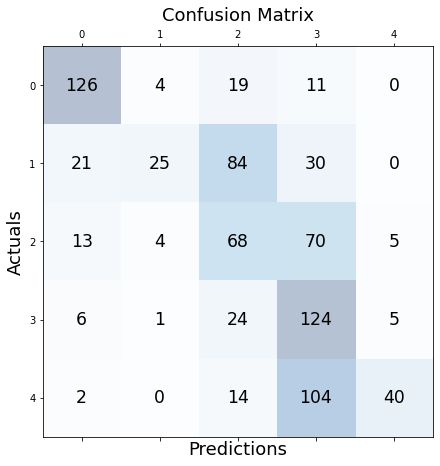

In [25]:
conf(conf_matrix41)

##### Val Confuison Matrix

In [26]:
yhat_val_m4 = model3.predict(x_val_resized)

4/4 [==============================] - 2s 357ms/step


In [27]:
yhat_val_m4

array([[1.01206236e-01, 3.78016033e-03, 2.15921160e-02, 6.29827917e-01,
        2.43593499e-01],
       [2.40047206e-03, 3.65747064e-02, 2.46565804e-01, 5.07101834e-01,
        2.07357213e-01],
       [1.64071738e-03, 7.27057829e-03, 8.66071358e-02, 3.48249763e-01,
        5.56231856e-01],
       [1.10914689e-02, 2.08989620e-01, 3.87413770e-01, 3.46671134e-01,
        4.58340086e-02],
       [6.63450062e-02, 4.03891414e-01, 3.98434490e-01, 1.15684405e-01,
        1.56445559e-02],
       [9.56988931e-01, 2.02404032e-03, 1.70988799e-03, 3.51727828e-02,
        4.10429295e-03],
       [1.63141396e-02, 6.94420785e-02, 3.81610602e-01, 3.04510981e-01,
        2.28122190e-01],
       [9.66759622e-01, 1.60268769e-02, 1.23732770e-02, 3.12035275e-03,
        1.71980914e-03],
       [4.53957528e-01, 1.25451565e-01, 2.69857824e-01, 7.55018443e-02,
        7.52312467e-02],
       [1.14777812e-03, 3.57662956e-03, 5.65167218e-02, 3.81388932e-01,
        5.57369828e-01],
       [1.79792717e-01, 1.7974

In [28]:
y_pred42 = yhat_val_m4.argmax(axis=1)
y_pred42

array([3, 3, 4, 2, 1, 0, 2, 0, 0, 4, 2, 4, 3, 2, 3, 0, 4, 2, 2, 0, 3, 3,
       2, 3, 2, 2, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 0, 3,
       3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 4, 1, 3, 0, 3, 2, 2, 0, 3, 0, 4,
       3, 3, 2, 3, 2, 3, 0, 2, 2, 0, 0, 0, 2, 3, 2, 1, 4, 1, 3, 3, 2, 0,
       0, 3, 2, 3, 3, 3, 3, 2, 3, 0, 2, 2])

In [29]:
conf_matrix42 = confusion_matrix(y_true=y_val, y_pred=y_pred42)
conf_matrix42

array([[14,  1,  3,  2,  0],
       [ 2,  3, 11,  4,  0],
       [ 0,  0,  7, 13,  0],
       [ 0,  1,  3, 14,  2],
       [ 0,  0,  2, 12,  6]])

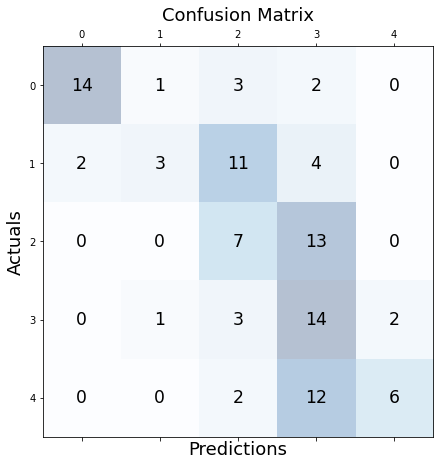

In [30]:
conf(conf_matrix42)

##### Testing Confuison Matrix

In [31]:
yhat_test_m4 = model3.predict(x_test_resized)

4/4 [==============================] - 2s 437ms/step


In [32]:
y_pred43 = yhat_test_m4.argmax(axis=1)
y_pred43

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 3, 0, 3, 2, 0, 0, 3, 3, 3,
       3, 2, 4, 4, 3, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 4, 0,
       3, 3, 4, 3, 4, 3, 0, 3, 3, 2, 4, 3, 4, 4, 3, 3, 3, 1, 1, 3, 3, 0,
       1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 2, 3, 1, 3, 2, 2, 2, 2,
       0, 4, 2, 4, 2, 2, 2, 3, 2, 2, 3, 3])

In [33]:
conf_matrix43 = confusion_matrix(y_true=y_test, y_pred=y_pred43)
conf_matrix43

array([[13,  0,  4,  3,  0],
       [ 1,  0,  2, 14,  3],
       [ 3,  0,  1, 10,  6],
       [ 5,  4,  8,  3,  0],
       [ 1,  1, 11,  5,  2]])

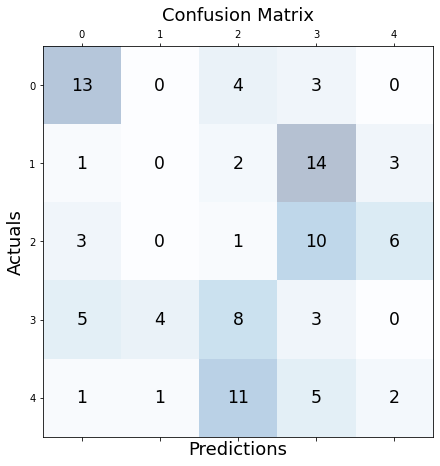

In [34]:
conf(conf_matrix43)


### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

We can see that the regularization and drop out could improve the performance of the model and reduce overfitting

And adding new data using Keras geneator for augmantation reduced the training and validation loss and increased the accuracy as the model could generalize more features of the dataset.

Write your discussion here.

## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.